---
<img src="../assets/grt_logo.png" style="float: left; margin: 20px; height: 55px">

# Garton Research & Trading

_August 16, 2019_

---

## Forecasting Futures Prices with LSTMs

---

**Context:** The purpose of this study is to experiment with implementing Long Short Term Memory neural networks to predict futures prices. The data for this study consists of continuous futures contracts (generic first nearby with naive rolling method) from the Wiki Continuous Futures dataset on [Quandl](https://www.quandl.com/data/CHRIS-Wiki-Continuous-Futures). The specific markets I chose to use are based on the markets used in the original ['Turtle Traders'](https://bigpicture.typepad.com/comments/files/turtlerules.pdf) strategy.

_Author: Matthew Garton_

In [1]:
# standard data science imports
import pandas as pd
import numpy as np
import datetime
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler

# necessary for plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# keras imports
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, GRU
from keras.preprocessing.sequence import TimeseriesGenerator
from keras import optimizers

Using TensorFlow backend.


### Import and Preprocess Data

In [2]:
# import a dataset
sugar = pd.read_csv('../data/ICE_SB1.csv', 
                    usecols=['Date','Settle'], 
                    index_col='Date', 
                    parse_dates=True)

In [3]:
sugar.head()

,Settle
Date,
1961-01-04,2.90
1961-01-05,2.91
1961-01-06,2.97
1961-01-09,3.01
1961-01-10,3.02


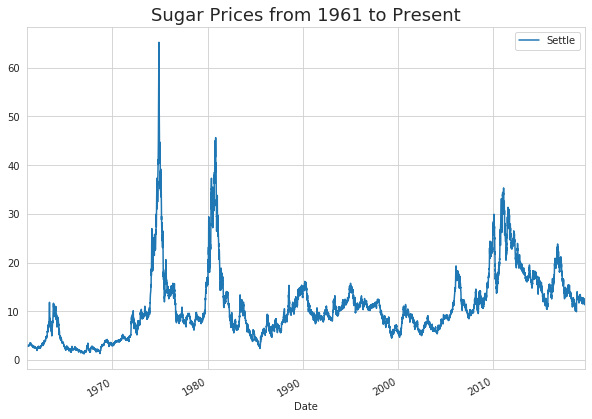

In [4]:
sugar.plot(figsize=(10,7))
plt.title('Sugar Prices from 1961 to Present', fontsize=18);

### Note on regimes and sampling

It is clear that the full history here is dominated by a few significant regimes. My expectation is that the LSTM model will be trained on a relatively short time span to predict an even shorter one, so looking at several decades of data which include some extreme events is unlikely to be successful. So I will choose a more recent subsample of the data to look at. Starting in the year 2000, in the middle of a 'boring' regime may be reasonable. I'll have to return to this later, but for now I'm satisfied with ignoring the extreme inflation of the 70's and 80's (with the knowledge that my strategy would become invalid if such a regime were to reappear).

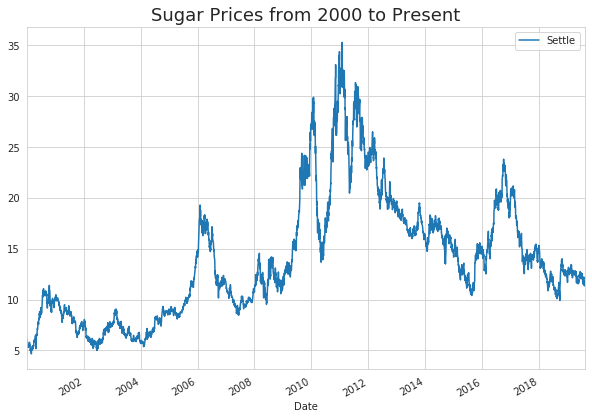

In [5]:
sugar = sugar['2000':]
sugar.plot(figsize=(10,7))
plt.title('Sugar Prices from 2000 to Present', fontsize=18);

### Difference the data until approximately stationary

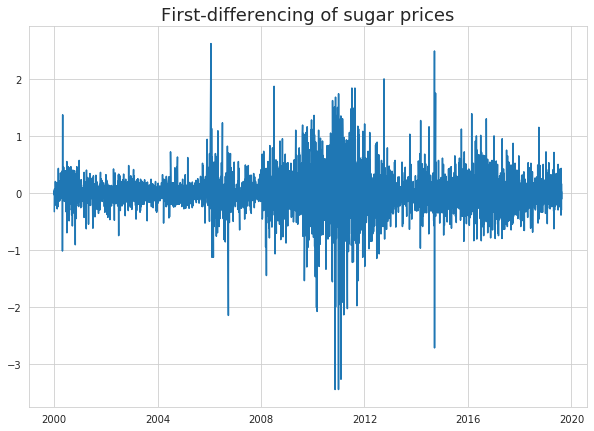

In [6]:
plt.figure(figsize=(10,7))
plt.plot(sugar['Settle'].diff())
plt.title('First-differencing of sugar prices', fontsize=18);

The data above appears roughly stationary based on a quick 'eyeball' test - it looks like a White Noise process. However, I want to define stationarity with more rigor, as well as have the functionality to algorithmically transform an arbitrary time series into a stationary one. Below I define two functions which should be applicable to any time series analysis:

* A function to difference the data until the (differenced) series 'passes' an augmented Dickey-Fuller test. This function will be called on the dataset before any modeling or other preprocessing.
* A function to invert the differencing that was necessary to achieve stationarity. This function will be called at the end of the modeling process, when I want to view my predictions in the original units of the time series.

**Note:** These functions only work for integer differencing. Generalizing to allow fractional differencing is something I hope to return to in a future iteration.

In [7]:
def make_stationary(ts, max_diff=3, p_value=0.05):
    '''
    Returns time series with d-order differencing, where d is the smallest
    order of differencing that achieves stationarity based on an augmented 
    Dicker-Fuller test
    Inputs:
    ts - pandas Series with datetime index
    dvals - range of d values to search over
    pval - pvalue cutoff to use for ADF test
    Outputs:
    ts_d - differenced time series
    startvals - list containing the first value of each ts before differencing.
        these can be used to invert the differening later
    '''
    ts_d = ts.copy()
    startvals = []
    for d in range(max_diff+1):
        startvals.append(ts_d.dropna()[0])
        ts_d = ts_d.diff()
        pval = adfuller(ts_d.dropna())[1]
        if pval < p_value:
            print(f'Order of differencing: {d+1}')
            return ts_d, startvals
        else:
            continue
    print('Cannot achieve stationarity. Review data or try a wider range.')
    
def invert_differencing(startvals, ts_diff):
    '''
    Inverse transform of time series differencing
    Inputs:
    startvals - starting points to add differences to
    ts_diff - d-differenced time series data
    Outputs:
    ts - un-differenced time series
    '''
    ts = ts_diff.copy()
    while startvals:
        for i in startvals[::-1]:
            ts.iloc[len(startvals)-1] = i
            startvals.pop()
            ts = ts.cumsum()
    return ts

### Format Data for LSTM

LSTM neural networks require input in a particular shape. I'll demonstrate two methods for preparing the data: one will be a more 'hands on' approach that is more explicit but requires more steps. Then, I'll make use of the `TimeSeriesGenerator` provided by `keras`. `TimeSeriesGenerator` is a time saver, but I prefer starting out with the manual approach, as data prep for neural nets can get convoluted (no pun intended) and it helps to be forced to keep track of the state of your data at each stage. This is especially crucial in time series forecasting, which typically involves transformations on the front-end that will have to be inverted at the end (i.e. differencing for stationarity).

**Citation:** Credit to Jason Brownlee, PhD and his blog [Machine Learning Mastery](https://machinelearningmastery.com/) which was an instrumental resource for me in learning LSTM workflows. I've endeavored to write my own functions where possible, but the code snippets in his blog were a great starting point.

In [8]:
# manual approach - define all functions I'll need
def generate_sequences(data, lags=7):
    '''
    Returns a time series that has been formatted for a supervised learning problem
    Inputs:
    data - time series data as a pandas Series
    lags - number of periods to look back
    Outputs:
    data - numpy array where each row includes columns of lagged observations
    '''    
    data = pd.DataFrame(data)
    columns = [data.shift(i) for i in range(1, lags+1)]
    columns.append(data)
    data = pd.concat(columns, axis=1)
    data.fillna(0, inplace=True)
    return data.values

def scale_data(train, test):
    '''
    MinMaxScale data before fitting LSTM
    Inputs:
    train, test - training and testing data
    Outputs:
    scaler - MinMaxScaler object fit to training data
    train_sc, test_sc - scaled training and testing data
    '''
    scaler = MinMaxScaler(feature_range=(-1, 1))
    #train = train.reshape(train.shape[0], train.shape[1])
    train = train.reshape(-1, 1)
    train_sc = scaler.fit_transform(train)
    
    #test = test.reshape(test.shape[0], test.shape[1])
    test = test.reshape(-1, 1)
    test_sc = scaler.transform(test)
    return scaler, train_sc, test_sc

### Data Transformation Pipeline

**Front-end:**
1. Difference the data for stationarity
2. Train-test Split
3. Scale the data --> MinMaxScaler in this case
4. Reshape data --> Convert to observations of sequences

**Back-end:**
1. Inverse scale
2. Inverse Difference
3. Re-combine all data

In [9]:
# transform data for lstm
def lstm_pipe(ts, train_size=0.7, lag_windows=7):
    
    # difference for stationarity
    data, startvals = make_stationary(ts)
    
    # train test split
    train_split = int(train_size*data.shape[0])
    train, test = data[0:train_split], data[train_split:data.shape[0]]
    
    # scale data
    scaler, train_sc, test_sc = scale_data(train.values, test.values)
    
    # convert to sequences
    train_samples = generate_sequences(train_sc, lags=lag_windows)
    test_samples = generate_sequences(test_sc, lags=lag_windows)
    
    # set up X and y for training
    X, y = train_samples[:, 0:-1], train_samples[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])

    # set up X and y for test data
    Xt, yt = test_samples[:, 0:-1], test_samples[:, -1]
    Xt = Xt.reshape(Xt.shape[0], 1, Xt.shape[1])
    
    return X, y, Xt, yt, startvals, scaler

In [10]:
# run the lstm pipe to prepare data
X, y, Xt, yt, startvals, scaler = lstm_pipe(sugar['Settle'])

Order of differencing: 1


### Build and train the LSTM

In [11]:
def train_lstm(model, X, y, Xt, yt, epochs=1, batch_size=1):
    '''
    Train the LSTM model and validate on testing data
    Inputs:
    model - compiled LSTM model
    X - training inputs
    y - training outputs
    Xt - validation inputs
    yt - validation outputs
    epochs - number of training epochs
    Outputs:
    model - LSTM model fit to training data
    model_hist - model history
    '''
    
    # instantiate empty dictionary for model history
    model_hist = {
        'loss': [],
        'val_loss': []
           }
    
    # reset the state of the model between each training epoch
    for i in range(epochs):
        history = model.fit(X, y, 
                            epochs=1, 
                            batch_size=batch_size,
                            verbose=0, 
                            shuffle=False,
                            validation_data=(Xt, yt))
        model_hist['loss'].extend(history.history['loss'])
        model_hist['val_loss'].extend(history.history['val_loss'])
        model.reset_states()
    
    print(model.summary())
    return model, model_hist

In [12]:
# initialize hyperparameters here
lag_windows = 7
neurons = 100
batch_size =  1
epochs = 500

Instructions for updating:
Colocations handled automatically by placer.


In [13]:
# define model architecture and build
model = Sequential()
model.add(LSTM(neurons, 
               activation='tanh',
               batch_input_shape=(batch_size, X.shape[1], X.shape[2]),
               stateful=True))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mse')

In [14]:
# train the model
model, model_hist = train_lstm(model, X, y, Xt, yt, batch_size=batch_size, epochs=epochs)

Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 100)                  43200     
_________________________________________________________________
dense_1 (Dense)              (1, 1)                    101       
Total params: 43,301
Trainable params: 43,301
Non-trainable params: 0
_________________________________________________________________
None


### Forecasting with the model

**Note:** to facilitate comparing predictions to actual data, I will need to reverse the transformations that I originally made to my data, so that I can ultimately plot 'prices' and 'predicted prices.'

In [18]:
yhat_train = model.predict(X, batch_size=1)

In [19]:
yhat = model.predict(Xt, batch_size=1)

### Inverse transform predictions

In [20]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# inverse transform model output for analysis and plotting
def inverse_lstm_pipe(yhat, history, scaler, d=1):
    '''
    Given output of LSTM, return predictions in the original units
    Inputs:
    yhat - output of lstm .predict()
    history - original full time series data
    scaler - scaler object fit to training data
    d - order of differencing
    Outputs:
    preds - predicted values in the original units of time series
    '''
    # inverse scale
    yhat = scaler.inverse_transform(yhat) 
    
    # inverse difference
    preds = []
    for i in range(len(yhat)):
        value = inverse_difference(history, yhat[i], len(yhat)-i)
        preds.append(value)    
    return preds

In [21]:
# pass predictions through inverse pipeline
history = sugar['Settle']
preds = inverse_lstm_pipe(yhat, history, scaler)

In [22]:
# create empty column to hold predictions
sugar['Predictions'] = np.empty_like(sugar['Settle'])
sugar['Predictions'] = np.nan

# add predictions back into dataframe
sugar['Predictions'].iloc[len(yhat_train):] = preds

### Analyze Results of Model

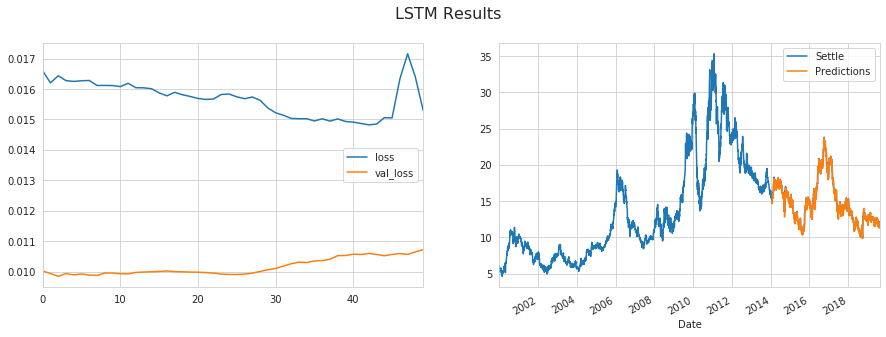

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
fig.suptitle("LSTM Results", fontsize=16)

model_hist = pd.DataFrame(model_hist)
model_hist[['loss', 'val_loss']].plot(ax=ax[0])
sugar[['Settle','Predictions']].plot(ax=ax[1]);

### Notes

The model is now working, and I have the transforms and inverse transforms to be able to manipulate my data. However, it is still challenging to interpret the results. Additionally, predicting only one step forward is of limited use and is likely too easy a problem. 

**Next Steps:**
1. Implement 'chain rule' forecasting where each step forward in the testing data uses forecasts rather than actual data to make the next forecast.
2. Write a method to perform residual analysis
3. Build a model to make multi-period forecasts, which I would hope is better than only predicting one step at a time.
4. Go from univariate to multivariate model - i.e. add exogenous variables.
5. Optimize by making everything compatible with NumPy (remove the need for pandas)
6. Implement Keras TimeSeriesGenerator
7. Try different targets (classification problem, triple barrier method, etc..)
8. Migrate from Keras --> TensorFlow --> PyTorch